# Brain Tumor Project (Local ZIP Upload)
**Last generated:** 2025-10-13 20:12:26 UTC

This Colab notebook trains a VGG16-based classifier for brain tumor detection and exports:
- `brain_tumor_classifier.keras`
- `class_names.json`

It also saves: `training_curves.png`, `confusion_matrix.png`.


In [1]:

# === Setup ===
!pip -q install imutils

import os, json, zipfile, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import cv2

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.keras.utils.set_random_seed(SEED)
print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:

# === Upload dataset ZIP from your device (no Drive needed) ===
DATA_DIR = "/content/dataset"  # change if running outside Colab
EXTRACT_INTO_SINGLE = True

def _maybe_step_into_single_folder(root_dir):
    entries = [e for e in os.listdir(root_dir) if not e.startswith(".")]
    if len(entries) == 1:
        candidate = os.path.join(root_dir, entries[0])
        if os.path.isdir(candidate):
            return candidate
    return root_dir

def _clean_and_make(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

try:
    from google.colab import files
    print("Please select your dataset ZIP...")
    uploaded = files.upload()
    zip_names = [name for name in uploaded.keys() if name.lower().endswith(".zip")]
    if not zip_names:
        raise RuntimeError("No .zip file uploaded.")
    zip_path = zip_names[0]

    _clean_and_make(DATA_DIR)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(DATA_DIR)
    if EXTRACT_INTO_SINGLE:
        DATA_DIR = _maybe_step_into_single_folder(DATA_DIR)
except Exception as e:
    print("Colab upload not used. If running locally, set DATA_DIR manually.")
    os.makedirs(DATA_DIR, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("Top-level entries:", os.listdir(DATA_DIR))


Please select your dataset ZIP...


Saving brain_tumor_dataset.zip to brain_tumor_dataset.zip
DATA_DIR: /content/dataset/brain_tumor_dataset
Top-level entries: ['no', 'yes']


In [3]:

# === Load images & labels from folder structure ===
# Expect: DATA_DIR/<class_name>/*.jpg|png|...
image_paths = list(paths.list_images(DATA_DIR))
if len(image_paths) == 0:
    raise FileNotFoundError(f"No images found under {DATA_DIR}. Ensure your ZIP contains folders by class.")

images, labels = [], []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    if image is None:
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    images.append(image)
    labels.append(label)

images = np.array(images, dtype=np.float32) / 255.0
labels = np.array(labels)

print("Total images:", images.shape, " | unique labels:", len(np.unique(labels)))


Total images: (253, 224, 224, 3)  | unique labels: 2


In [4]:

# === Encode labels & split ===
label_binarizer = LabelBinarizer()
labels_bin = label_binarizer.fit_transform(labels)
labels_cat = to_categorical(labels_bin)
class_names = list(label_binarizer.classes_)
print("Classes:", class_names)

(train_X, test_X, train_Y, test_Y) = train_test_split(
    images, labels_cat, test_size=0.10, random_state=SEED, stratify=labels_cat
)
train_X.shape, test_X.shape


Classes: [np.str_('no'), np.str_('yes')]


((227, 224, 224, 3), (26, 224, 224, 3))

In [5]:

# === Build VGG16-based model ===
base_model = VGG16(weights='imagenet', input_tensor=Input(shape=(224, 224, 3)), include_top=False)
x = base_model.output
x = AveragePooling2D(pool_size=(4, 4))(x)
x = Flatten(name="flatten")(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation="softmax")(x)

for layer in base_model.layers:
    layer.trainable = False

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 512)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 32,962 (128.76 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:

# === Train ===
batch_size = 8
epochs = 10

history = model.fit(
    train_X, train_Y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_X, test_Y),
    verbose=1
)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.5203 - loss: 0.8919 - val_accuracy: 0.6538 - val_loss: 0.6410
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6096 - loss: 0.6624 - val_accuracy: 0.6923 - val_loss: 0.6139
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6616 - loss: 0.5846 - val_accuracy: 0.6154 - val_loss: 0.5858
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7527 - loss: 0.5465 - val_accuracy: 0.6923 - val_loss: 0.5619
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7976 - loss: 0.5203 - val_accuracy: 0.6154 - val_loss: 0.5510
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7557 - loss: 0.5048 - val_accuracy: 0.7308 - val_loss: 0.5354
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7937 - loss: 0.5013 - val_accuracy: 0.7308 - val_loss: 0.5225
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8107 - loss: 0.4571 - val_accuracy: 0.7692 -

In [7]:

# === Evaluate & predictions ===
from sklearn.metrics import classification_report, confusion_matrix

probs = model.predict(test_X, batch_size=batch_size, verbose=0)
predictions = np.argmax(probs, axis=1)
actuals = np.argmax(test_Y, axis=1)

print("\nClassification report:")
print(classification_report(actuals, predictions, target_names=class_names))

cm = confusion_matrix(actuals, predictions)
print("Confusion matrix:\n", cm)
acc_from_cm = (cm.diagonal().sum() / cm.sum()) if cm.sum() > 0 else 0.0
print("Accuracy (from CM): {:.4f}".format(acc_from_cm))



Classification report:
              precision    recall  f1-score   support

          no       0.67      0.40      0.50        10
         yes       0.70      0.88      0.78        16

    accuracy                           0.69        26
   macro avg       0.68      0.64      0.64        26
weighted avg       0.69      0.69      0.67        26

Confusion matrix:
 [[ 4  6]
 [ 2 14]]
Accuracy (from CM): 0.6923


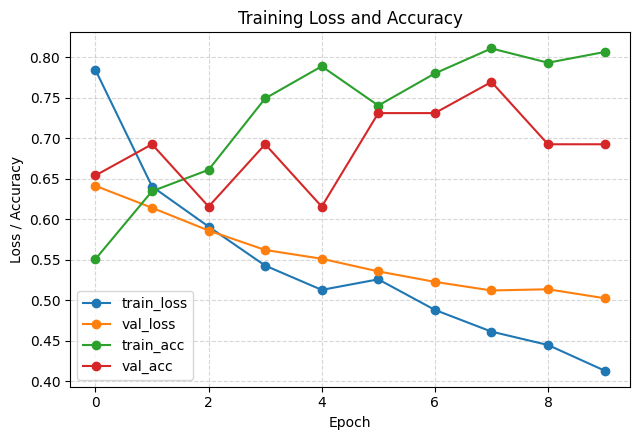

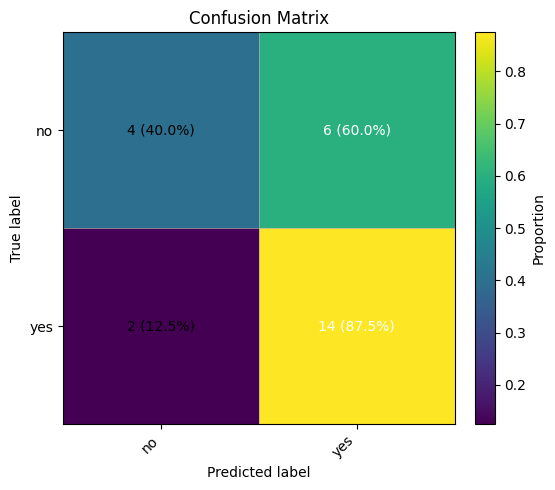

In [8]:

# === Save training curves & pretty confusion matrix ===
# Training curves
plt.figure(figsize=(6.5, 4.5))
N = len(history.history["loss"])
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss", marker="o")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss", marker="o")
if "accuracy" in history.history and "val_accuracy" in history.history:
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc", marker="o")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc", marker="o")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Loss / Accuracy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("training_curves.png"); plt.show()

# Pretty confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title="Confusion Matrix", outpath="confusion_matrix.png"):
    cm = np.array(cm)
    if normalize:
        cm_sum = cm.sum(axis=1, keepdims=True)
        cm_sum[cm_sum == 0] = 1
        cm_norm = cm / cm_sum
    else:
        cm_norm = cm.astype(float)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm_norm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)

    thresh = cm_norm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)" if normalize else f"{cm[i, j]}"
            ax.text(j, i, txt, ha="center", va="center",
                    color="white" if cm_norm[i, j] > thresh else "black")

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Proportion" if normalize else "Count")
    ax.set_xticks(np.arange(-.5, cm.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, cm.shape[0], 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.tight_layout(); plt.savefig(outpath); plt.show()

plot_confusion_matrix(cm, class_names, normalize=True, outpath="confusion_matrix.png")


In [9]:

# === Export artifacts for Streamlit repo ===
model.save("brain_tumor_classifier.keras")
with open("class_names.json", "w") as f:
    json.dump(class_names, f)
print("Saved: brain_tumor_classifier.keras, class_names.json")

# Optional: download in Colab
try:
    from google.colab import files
    files.download("brain_tumor_classifier.keras")
    files.download("class_names.json")
    files.download("training_curves.png")
    files.download("confusion_matrix.png")
except Exception:
    pass


Saved: brain_tumor_classifier.keras, class_names.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>